# All import's

In [1]:
! pip install pyfpgrowth

     |████████████████████████████████| 1.6MB 2.8MB/s 
  Created wheel for pyfpgrowth: filename=pyfpgrowth-1.0-py2.py3-none-any.whl size=5479 sha256=839b1c059139f660b11adc7cb646e8c872771d21b7d594d272cce5e86a7151ad
  Stored in directory: /root/.cache/pip/wheels/3b/3f/0d/a04bb8b17887c1eca7d0f1a48d4aa0c09c96eb221ff7fa56c1
Successfully built pyfpgrowth


In [0]:
import os
from google_drive_downloader import GoogleDriveDownloader as gdd

import pandas as pd
import seaborn as sns
import numpy as np
import  matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression

import pyfpgrowth
from umap import UMAP
from sklearn.manifold import TSNE
import gc
from tqdm import tqdm

In [0]:
sns.set_style('darkgrid')

# Install pyfim

In [0]:
!wget http://www.borgelt.net/src/pyfim.zip

--2019-11-18 14:14:11--  http://www.borgelt.net/src/pyfim.zip
Resolving www.borgelt.net (www.borgelt.net)... 134.0.30.202, 2a03:2900:7::13
Connecting to www.borgelt.net (www.borgelt.net)|134.0.30.202|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 881543 (861K) [application/zip]
Saving to: ‘pyfim.zip’

pyfim.zip           100%[===================>] 860.88K   134KB/s    in 13s     

2019-11-18 14:14:25 (68.4 KB/s) - ‘pyfim.zip’ saved [881543/881543]



In [0]:
!unzip -q pyfim.zip

In [0]:
!python setup_fim.py install

running install
running build
running build_ext
building 'fim' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/util
creating build/temp.linux-x86_64-3.6/util/src
creating build/temp.linux-x86_64-3.6/math
creating build/temp.linux-x86_64-3.6/math/src
creating build/temp.linux-x86_64-3.6/tract
creating build/temp.linux-x86_64-3.6/tract/src
creating build/temp.linux-x86_64-3.6/apriori
creating build/temp.linux-x86_64-3.6/apriori/src
creating build/temp.linux-x86_64-3.6/eclat
creating build/temp.linux-x86_64-3.6/eclat/src
creating build/temp.linux-x86_64-3.6/fpgrowth
creating build/temp.linux-x86_64-3.6/fpgrowth/src
creating build/temp.linux-x86_64-3.6/sam
creating build/temp.linux-x86_64-3.6/sam/src
creating build/temp.linux-x86_64-3.6/relim
creating build/temp.linux-x86_64-3.6/relim/src
creating build/temp.linux-x86_64-3.6/carpenter
creating build/temp.linux-x86_64-3.6/carpenter/src
creating build/temp.linux-x86_64-3.6/ista
creating buil

In [0]:
from fim import fpgrowth

# Load data

In [25]:
if not os.path.exists('./data'):
  os.mkdir('./data')

gdd.download_file_from_google_drive(file_id='1EMS377_Ew2h0esEMdEj54X894J_xU7Fl', dest_path='./data/instacart_online_grocery_shopping_2017_05_01.tar.gz')
gdd.download_file_from_google_drive(file_id='1LdRp0AHS0bkZkdLCOpFs-4SXrFJaERmg', dest_path='./data/basic_recommenders.py')



In [0]:
! mkdir ./data/unziped

In [0]:
! tar -xzf ./data/instacart_online_grocery_shopping_2017_05_01.tar.gz -C ./data/unziped

Load basic recommenders implementation

In [0]:
import data.basic_recommenders as br

# EDA

Table with info about order

In [0]:
orders_df = pd.read_csv('./data/unziped/instacart_2017_05_01/orders.csv')

We have orders, but no items here.

In [0]:
orders_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


We have nans only in days_since_prior_order column.

In [0]:
orders_df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
order_id                  3421083 non-null int64
user_id                   3421083 non-null int64
eval_set                  3421083 non-null object
order_number              3421083 non-null int64
order_dow                 3421083 non-null int64
order_hour_of_day         3421083 non-null int64
days_since_prior_order    3214874 non-null float64
dtypes: float64(1), int64(5), object(1)
memory usage: 182.7+ MB


Investigate eval_set

In [0]:
orders_df['eval_set'].value_counts()

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

At first drop eval_set = test, because we have no private data

In [0]:
orders_df = orders_df.drop(orders_df[orders_df['eval_set'] == 'test'].index)

In [0]:
orders_df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3346083 entries, 0 to 3421082
Data columns (total 7 columns):
order_id                  3346083 non-null int64
user_id                   3346083 non-null int64
eval_set                  3346083 non-null object
order_number              3346083 non-null int64
order_dow                 3346083 non-null int64
order_hour_of_day         3346083 non-null int64
days_since_prior_order    3139874 non-null float64
dtypes: float64(1), int64(5), object(1)
memory usage: 204.2+ MB


No duplicates in order_id

In [0]:
orders_df.nunique()

order_id                  3346083
user_id                    206209
eval_set                        2
order_number                  100
order_dow                       7
order_hour_of_day              24
days_since_prior_order         31
dtype: int64

In [0]:
orders_df['order_dow'].unique()

array([2, 3, 4, 1, 5, 0, 6])

In [0]:
orders_df['order_hour_of_day'].unique()

array([ 8,  7, 12, 15,  9, 14, 16, 11, 10, 19, 18, 17, 13, 20,  0, 21, 22,
        5, 23,  4,  6,  1,  2,  3])

In [0]:
orders_df['days_since_prior_order'].unique()

array([nan, 15., 21., 29., 28., 19., 20., 14.,  0., 30., 10.,  3.,  8.,
       13., 27.,  6.,  9., 12.,  7., 17., 11.,  4.,  5.,  2., 23., 26.,
       25., 16.,  1., 18., 24., 22.])

1. All order_id are unique
2. We have 206209 unique users
3. order_dow, order_hour_of_day, days_since_prior_order correspond their description

Fill na in days_since_prior_order as 999

In [0]:
orders_df.fillna(999, inplace=True)

When people make orders?

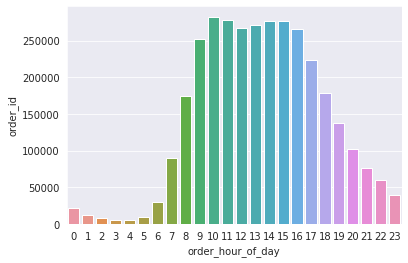

In [0]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
sns.barplot(data=orders_df.groupby('order_hour_of_day').agg({'order_id':'count'}).reset_index(), x='order_hour_of_day', y='order_id',ax=ax)

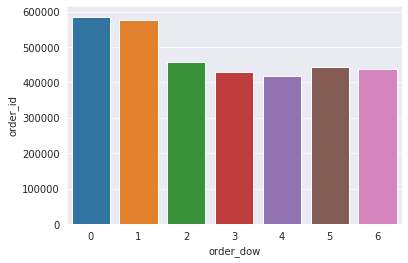

In [0]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
sns.barplot(data=orders_df.groupby('order_dow').agg({'order_id':'count'}).reset_index(), x='order_dow', y='order_id',ax=ax)

When people reorder

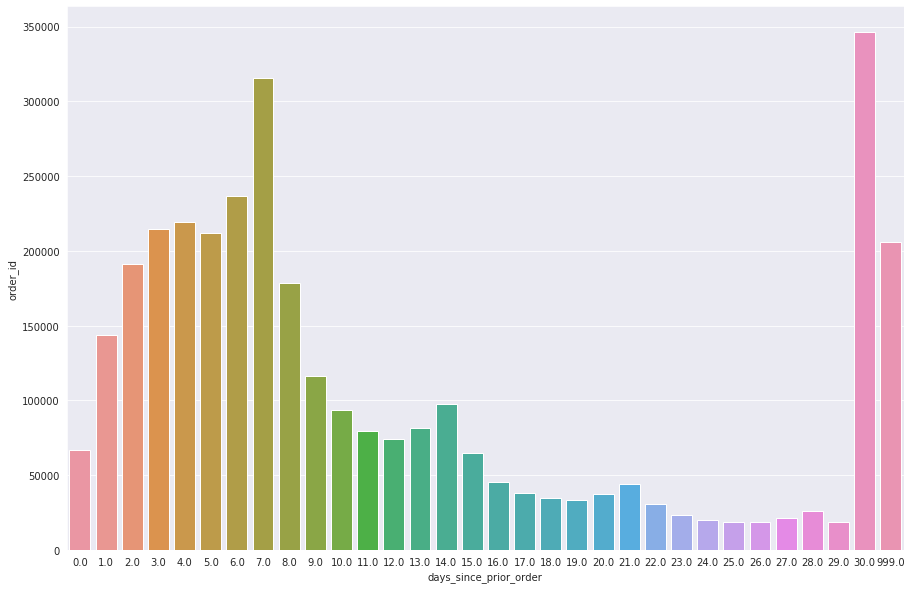

In [0]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)
sns.barplot(data=orders_df.groupby('days_since_prior_order').agg({'order_id':'count'}).reset_index(), x='days_since_prior_order', y='order_id',ax=ax)

Distribution of orders number within users

Interesting outlier

Text(0.5, 0, 'orders per user')

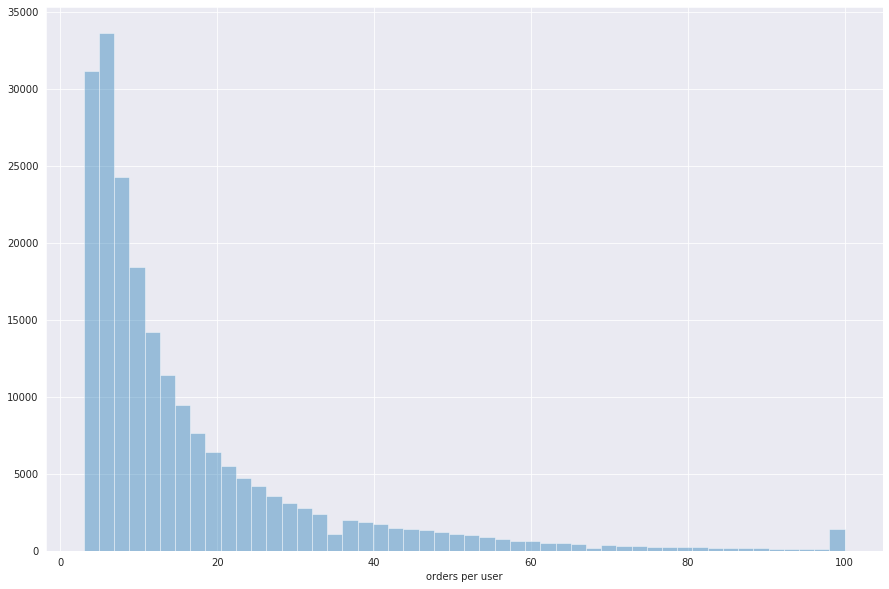

In [0]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1)
sns.distplot(orders_df['user_id'].value_counts(),kde=False,ax=ax)
ax.set_xlabel('orders per user')

Table with prior orders

In [0]:
order_products_prior_df = pd.read_csv('./data/unziped/instacart_2017_05_01/order_products__prior.csv')

In [0]:
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


No nulls

In [0]:
order_products_prior_df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
order_id             32434489 non-null int64
product_id           32434489 non-null int64
add_to_cart_order    32434489 non-null int64
reordered            32434489 non-null int64
dtypes: int64(4)
memory usage: 989.8 MB


In [0]:
order_products_prior_df.nunique()

order_id             3214874
product_id             49677
add_to_cart_order        145
reordered                  2
dtype: int64

No duplicates

In [0]:
order_products_prior_df.duplicated().any()

False

Table with train orders

In [0]:
order_products_train_df = pd.read_csv('./data/unziped/instacart_2017_05_01/order_products__train.csv')

In [0]:
order_products_train_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


No nulls

In [0]:
order_products_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384617 entries, 0 to 1384616
Data columns (total 4 columns):
order_id             1384617 non-null int64
product_id           1384617 non-null int64
add_to_cart_order    1384617 non-null int64
reordered            1384617 non-null int64
dtypes: int64(4)
memory usage: 42.3 MB


In [0]:
order_products_train_df.nunique()

order_id             131209
product_id            39123
add_to_cart_order        80
reordered                 2
dtype: int64

No duplicates

In [0]:
order_products_train_df.duplicated().any()

False

We have no test orders table

Just load products, investigation later

In [0]:
products_df = pd.read_csv('./data/unziped/instacart_2017_05_01/products.csv')

Check mapping order_products_train/prior, orders and products

In [0]:
set(order_products_train_df['product_id'].unique()).issubset(set(products_df['product_id'].unique()))

True

In [0]:
set(order_products_prior_df['product_id'].unique()).issubset(set(products_df['product_id'].unique()))

True

In [0]:
set(orders_df.loc[orders_df['eval_set']=='train',:]['order_id'].unique()) == set(order_products_train_df['order_id'].unique())

True

In [0]:
set(orders_df.loc[orders_df['eval_set']=='prior',:]['order_id'].unique()) == set(order_products_prior_df['order_id'].unique())

True

So, no problem with mapping

Concatenate order_products_train/prior 

In [0]:
concated_df = pd.concat([order_products_prior_df, order_products_train_df])

Distribution of items number per order in prior

Text(0.5, 0, 'number of items in order')

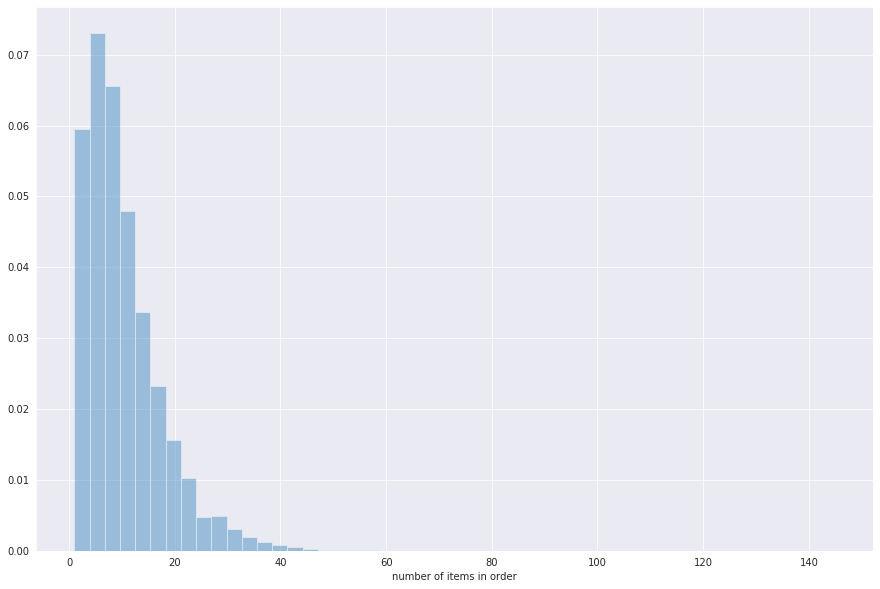

In [0]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1)
sns.distplot(concated_df['order_id'].value_counts(),kde=False,ax=ax, norm_hist=True)
ax.set_xlabel('number of items in order')

Check most popular items 

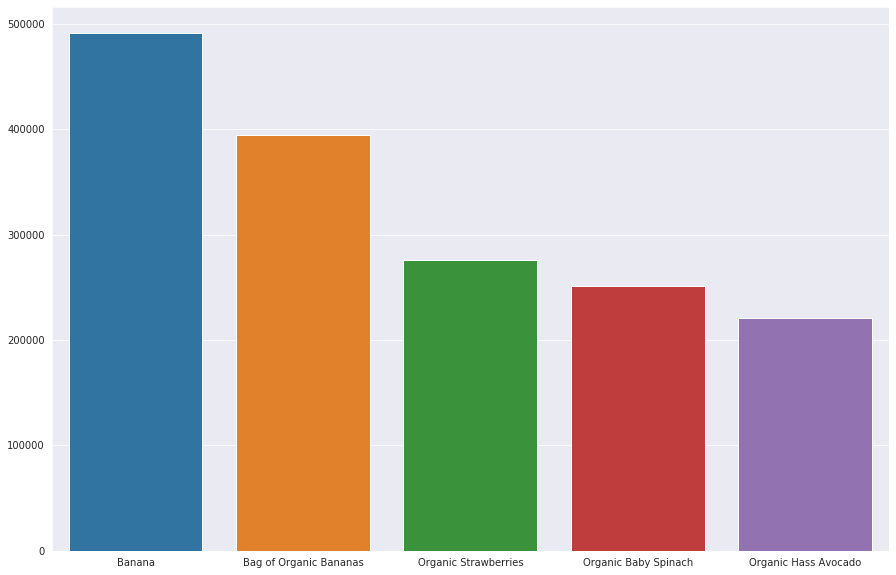

In [0]:
merged = concated_df.merge(products_df,on='product_id',how='left')['product_name'].value_counts()[:5]
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1)
sns.barplot(x=merged.index, y=merged.values,ax=ax)

Table with info about products

In [0]:
products_df.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


No nulls

In [0]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
product_id       49688 non-null int64
product_name     49688 non-null object
aisle_id         49688 non-null int64
department_id    49688 non-null int64
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


No duplicates into product_id and product_name

In [0]:
products_df.nunique()

product_id       49688
product_name     49688
aisle_id           134
department_id       21
dtype: int64

Try to find dummy

In [0]:
concated_df.merge(products_df,on='product_id',how='left').groupby('product_name').agg({'order_id':'count'}).sort_values(by='order_id', ascending=False)[:20]

,order_id
product_name,
Banana,491291
Bag of Organic Bananas,394930
Organic Strawberries,275577
Organic Baby Spinach,251705
Organic Hass Avocado,220877
Organic Avocado,184224
Large Lemon,160792
Strawberries,149445
Limes,146660


In [0]:
products_df['product_name'].str.contains('coupon').any()

False

In [0]:
products_df['product_name'].str.contains('points').any()

False

In [0]:
products_df['product_name'].str.contains('dummy').any()

False

It seems that there are no dummy

Table with info about aisles

In [0]:
aisles_df = pd.read_csv('./data/unziped/instacart_2017_05_01/aisles.csv')

In [0]:
aisles_df.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


No nulls

In [0]:
aisles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
aisle_id    134 non-null int64
aisle       134 non-null object
dtypes: int64(1), object(1)
memory usage: 2.2+ KB


No duplicates

In [0]:
aisles_df.nunique()

aisle_id    134
aisle       134
dtype: int64

Table with info about departments

In [0]:
departments_df = pd.read_csv('./data/unziped/instacart_2017_05_01/departments.csv')

In [0]:
departments_df.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


No nulls

In [0]:
departments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
department_id    21 non-null int64
department       21 non-null object
dtypes: int64(1), object(1)
memory usage: 464.0+ bytes


No duplicates

In [0]:
departments_df.nunique()

department_id    21
department       21
dtype: int64

Check mapping between aisles, products and departments

In [0]:
set(aisles_df['aisle_id'].unique()) == set(products_df['aisle_id'].unique())

True

In [0]:
set(departments_df['department_id'].unique()) == set(products_df['department_id'].unique())

True

How often people reorder items?

Text(0.5, 0, 'reordered')

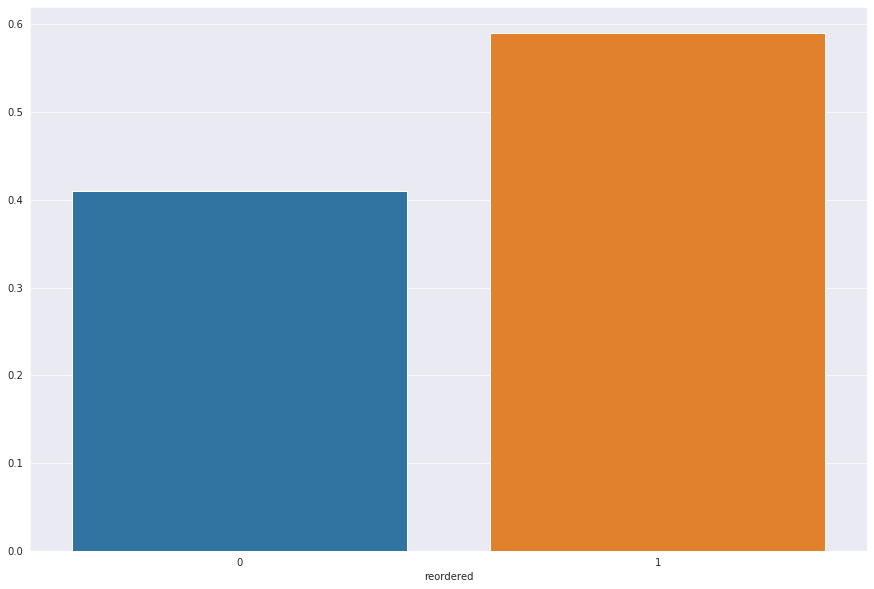

In [0]:
merged = concated_df['reordered'].value_counts(normalize=True)
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1)
sns.barplot(x=merged.index, y=merged.values,ax=ax)
ax.set_xlabel('reordered')

Which products are first in order?

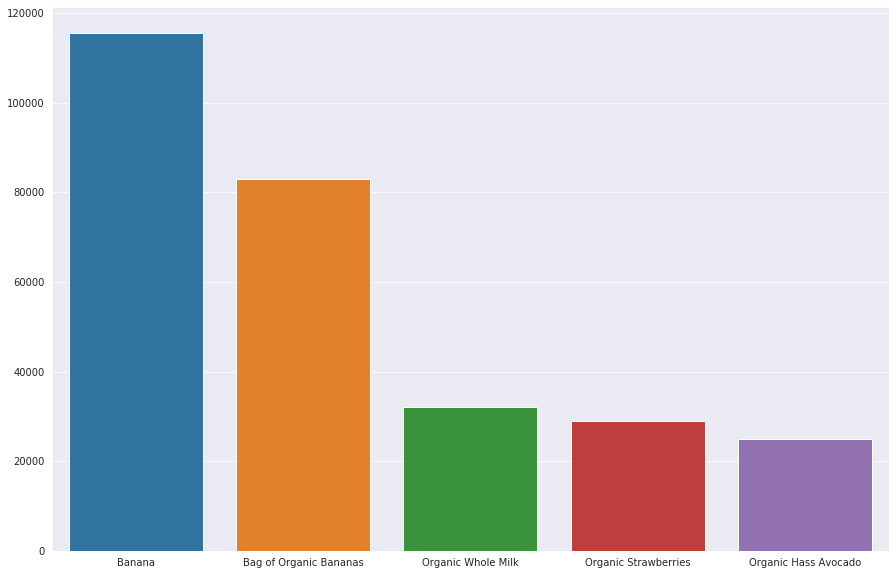

In [0]:
merged = concated_df.query('add_to_cart_order == 1').merge(products_df,on='product_id',how='left')['product_name'].value_counts()[:5]
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1)
sns.barplot(x=merged.index, y=merged.values,ax=ax)

We can see that most popular products are first in order

Distribution of products by aisles

In [0]:
aisles_df['aisle'].nunique()

134

In [0]:
merged_df = pd.merge(concated_df, products_df, on='product_id')

In [0]:
calc_prod_num_by_aisle = merged_df.groupby('aisle_id').agg({'product_id':'count'}).reset_index().rename(columns={'product_id':'num_of_products'}).merge(aisles_df, on='aisle_id')

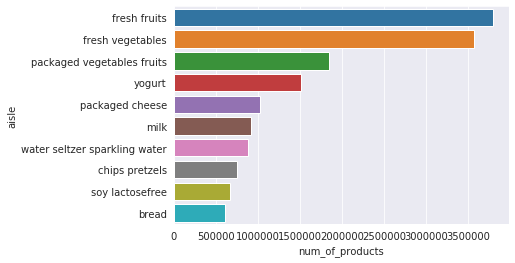

In [0]:
sns.barplot(data=calc_prod_num_by_aisle.sort_values(by='num_of_products', ascending=False).iloc[:10],x='num_of_products', y='aisle')

Most frequent are fruits and vegetables

Check whether all products are unique in one order

In [0]:
tmp_df = concated_df.groupby('order_id').agg(
    product_num=pd.NamedAgg(column='product_id', aggfunc='count'),
    product_nunique = pd.NamedAgg(column='product_id', aggfunc='nunique'))
sum(tmp_df['product_num'] != tmp_df['product_nunique'])

0

So all products in one order are unique

We have 1 order per user in train

In [0]:
orders_df[orders_df['eval_set'] == 'train'].groupby('user_id').agg({'order_id' : 'nunique'}).max()

order_id    1
dtype: int64

Distribution of orders per user in prior

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4697d27eb8>]],
      dtype=object)

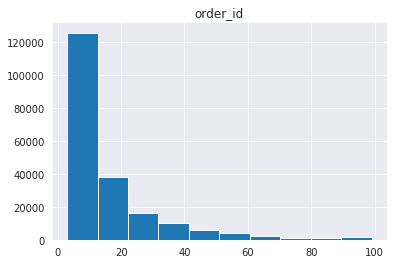

In [0]:
orders_df[orders_df['eval_set'] == 'prior'].groupby('user_id').agg({'order_id' : 'nunique'}).hist()

3 orders per user in prior minimum

In [0]:
orders_df[orders_df['eval_set'] == 'prior'].groupby('user_id').agg({'order_id' : 'nunique'}).min()

order_id    3
dtype: int64

# Metrics

In [0]:
def precision_at_k(predicted, actual, k):
  assert len(predicted) >= k
  intersection = set(predicted[:k]) & set(actual)
  return len(intersection) / k

In [0]:
def average_precision_at_k(predicted, actual, k):
  tmp = 0
  actual_length = min(k,len(actual))
  if len(predicted) < actual_length:
    warnings.warn("Length of predict is less than k")
  for i in range(actual_length):
    if predicted[i] in actual:
      tmp += precision_at_k(predicted[:i+1], actual, i+1)
  return tmp / actual_length

In [0]:
def mean_average_precision_at_k(predicted_list, actual_list, k):
  tmp = 0
  cnt = 0
  for predicted, actual in zip(predicted_list, actual_list):
    if len(actual) != 0:
      tmp += average_precision_at_k(predicted, actual, k)
      cnt += 1
  assert cnt != 0
  return tmp / cnt

# Basic Recommenders

In [0]:
train_orders_merged_df = pd.merge(orders_df[orders_df['eval_set'] == 'train'], order_products_train_df, on='order_id')
prior_orders_merged_df = pd.merge(orders_df[orders_df['eval_set'] == 'prior'], order_products_prior_df, on='order_id')

Helps eval performance

In [0]:
def eval_results(actual, predicted,k):

  def collect(x):
    return list(x)
  
  ground_truth = actual.groupby('user_id').agg({'product_id':collect})
  return mean_average_precision_at_k(list(predicted['product_id']), list(ground_truth['product_id']), k)

In [22]:
svd_rec = br.SVDRecommender(20, 4000)
svd_rec.fit(prior_orders_merged_df)
predicted = svd_rec.predict(train_orders_merged_df,top_n=5)
eval_results(train_orders_merged_df, predicted,5)

100%|██████████| 32/32 [10:39<00:00, 19.95s/it]


0.1371797496954061

In [27]:
mp = br.MostPopularRecommender()
mp.fit(prior_orders_merged_df)
predicted = mp.predict(train_orders_merged_df,top_n=5)
eval_results(train_orders_merged_df, predicted,5)

0.06033834061179575

# FPGrow Recommender

In [0]:
train_orders_merged_df = pd.merge(orders_df[orders_df['eval_set'] == 'train'], order_products_train_df, on='order_id')
prior_orders_merged_df = pd.merge(orders_df[orders_df['eval_set'] == 'prior'], order_products_prior_df, on='order_id')

In [0]:
def collect_products(x):
  return list(x.values)

In [0]:
transactions_df = prior_orders_merged_df.groupby('order_id').agg({'product_id' : collect_products}).reset_index()\
.rename(columns={'product_id':'transaction'})

In [0]:
transactions_list = list(transactions_df['transaction'].values)

In [0]:
len(transactions_list)

3214874

## pyfpgrowth

In [0]:
%%time
patterns = pyfpgrowth.find_frequent_patterns(transactions_list, int(0.03*len(transactions_list)))

CPU times: user 27.8 s, sys: 53.9 ms, total: 27.9 s
Wall time: 27.9 s


In [0]:
patterns

{(13176,): 379450,
 (16797,): 142951,
 (21137,): 264683,
 (21903,): 241921,
 (22935,): 113426,
 (24852,): 472565,
 (24964,): 109778,
 (26209,): 140627,
 (27845,): 137905,
 (27966,): 137057,
 (39275,): 100060,
 (45007,): 104823,
 (47209,): 213584,
 (47626,): 152657,
 (47766,): 176815,
 (49683,): 97315}

Absolutely impossible to use pyfpgrowth. Here support is 321487 and it more than hour, but we need support approximately 1000. Time grows exponentially.

## pyfim

In [0]:
freq_itemsets = list(fpgrowth(transactions_list, supp=-3000, zmin=3))

In [0]:
len(freq_itemsets)

278

In [0]:
freq_itemsets[0]

((21903, 21137, 24852), 9452)

In [0]:
freq_itemsets = sorted(freq_itemsets, key=lambda x: x[1],reverse=True)

In [0]:
prior_orders_merged_df

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,999.0,196,1,0
1,2539329,1,prior,1,2,8,999.0,14084,2,0
2,2539329,1,prior,1,2,8,999.0,12427,3,0
3,2539329,1,prior,1,2,8,999.0,26088,4,0
4,2539329,1,prior,1,2,8,999.0,26405,5,0
...,...,...,...,...,...,...,...,...,...,...
32434484,2977660,206209,prior,13,1,12,7.0,14197,5,1
32434485,2977660,206209,prior,13,1,12,7.0,38730,6,0
32434486,2977660,206209,prior,13,1,12,7.0,31477,7,0
32434487,2977660,206209,prior,13,1,12,7.0,6567,8,0


Train most popular - it will help us if association rules recommendations not enough

In [0]:
mp = MostPopularRecommender()
mp.fit(prior_orders_merged_df)

Build recommendation for 1 user: iterate through all products in cart and all frequent itemsets. If not enough recommendations -> add from most popular, if too much recommendations -> remove things that customer has never bought before.

In [0]:
def build_rec_for_user(products, itemsets, prior_user_products, top_n=5):
  recommendation = set()
  for product in products:
    for itemset in itemsets:
      if product in itemset[0]:
        recommendation.update(itemset[0])
  # remove products which are in this order already
  recommendation = list(recommendation.difference(set(products)))
  # truncate recommendation
  trunc_recommendation = []
  if len(recommendation) > top_n:
    for rec in recommendation:
      if rec in prior_user_products:
        trunc_recommendation.append(rec)
        if len(trunc_recommendation) == top_n:
          break
  recommendation = trunc_recommendation
  if len(recommendation) < top_n:
    recommendation.extend(mp.most_popular[:top_n-len(recommendation)])
  

  return recommendation

In [0]:
def eval_results(actual, predicted,k):

  def collect(x):
    return list(x)
  
  ground_truth = actual.groupby('user_id').agg({'product_id':collect}).reset_index()
  return mean_average_precision_at_k(list(predicted['product_id']), list(ground_truth['product_id']), k)

Calc number of products in order

In [0]:
def calc_prod_in_cart(df):
  return df.groupby('order_id').agg(num_of_prods_in_cart=pd.NamedAgg(column='add_to_cart_order', aggfunc='max')).reset_index()['num_of_prods_in_cart']

In [0]:
number_of_products_in_cart = train_orders_merged_df.groupby('order_id').agg(num_of_prods_in_cart=pd.NamedAgg(column='add_to_cart_order', aggfunc='max')).reset_index()

We make prediction only on orders with number of products > 10

In [0]:
full_df = pd.merge(train_orders_merged_df, number_of_products_in_cart.query('num_of_prods_in_cart > 10'), on='order_id')

First 5 products in train, all that remains to test

In [0]:
train_df, test_df = full_df.query('add_to_cart_order <= 5'), full_df.query('add_to_cart_order > 5')

In [0]:
train_df.shape, test_df.shape

((264240, 11), (690968, 11))

In [0]:
grouped_by_user_test = test_df.groupby('user_id').agg({'product_id':lambda x: list(x)})
grouped_by_user_train = train_df.groupby('user_id').agg({'product_id':lambda x: list(x)})
grouped_by_user_prior = prior_orders_merged_df.groupby('user_id').agg({'product_id':lambda x: list(x)})

In [0]:
grouped_by_user_test

,product_id
user_id,
1,"[10258, 13032, 26088, 27845, 49235, 46149]"
2,"[22825, 13640, 24852, 45066, 9387, 5450, 24838..."
8,"[4853, 27104, 7058, 41259, 37803, 48230, 47766..."
9,"[12075, 8467, 38988, 30252, 18926, 24954, 4057..."
14,"[37434, 3808, 15172, 8744, 29509, 42284]"
...,...
206198,"[39021, 21709, 47107, 10411, 44142, 14897, 159..."
206199,"[38341, 43821, 38930, 12127, 49198, 22242, 770..."
206200,"[27451, 15592, 47209, 22312, 23484, 8955, 4697..."


In [0]:
predicted = pd.DataFrame(columns=('user_id', 'product_id'))
predicted['user_id'] = list(test_df['user_id'].unique())
predicted['product_id'] = [build_rec_for_user(grouped_by_user_train.loc[user,'product_id'], freq_itemsets, grouped_by_user_prior.loc[user, 'product_id'],3)\
 for user in predicted['user_id'].unique()]

In [0]:
predicted

,user_id,product_id
0,1,"[24852, 13176, 21137]"
1,2,"[24852, 13176, 21137]"
2,8,"[24852, 13176, 21137]"
3,9,"[24852, 13176, 21137]"
4,14,"[24852, 13176, 21137]"
...,...,...
52843,206198,"[24852, 13176, 21137]"
52844,206199,"[24852, 13176, 21137]"
52845,206200,"[47626, 37646, 21903]"
52846,206203,"[24852, 13176, 21137]"


In [0]:
eval_results(test_df, predicted, 3)

0.09579464796313851

# Switcher

## Mining features for users

In [0]:
train_orders_merged_df = pd.merge(orders_df[orders_df['eval_set'] == 'train'], order_products_train_df, on='order_id')

Mining only in prior

In [0]:
prior_orders_merged_df = pd.merge(orders_df[orders_df['eval_set'] == 'prior'], order_products_prior_df, on='order_id')

In [0]:
prior_orders_merged_df

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,999.0,196,1,0
1,2539329,1,prior,1,2,8,999.0,14084,2,0
2,2539329,1,prior,1,2,8,999.0,12427,3,0
3,2539329,1,prior,1,2,8,999.0,26088,4,0
4,2539329,1,prior,1,2,8,999.0,26405,5,0
...,...,...,...,...,...,...,...,...,...,...
32434484,2977660,206209,prior,13,1,12,7.0,14197,5,1
32434485,2977660,206209,prior,13,1,12,7.0,38730,6,0
32434486,2977660,206209,prior,13,1,12,7.0,31477,7,0
32434487,2977660,206209,prior,13,1,12,7.0,6567,8,0


In [0]:
orders_df

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,999.0
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
...,...,...,...,...,...,...,...
3421078,2266710,206209,prior,10,5,18,29.0
3421079,1854736,206209,prior,11,4,10,30.0
3421080,626363,206209,prior,12,1,12,18.0
3421081,2977660,206209,prior,13,1,12,7.0


In [0]:
def generate_features(data_df):
  user_features1_df = data_df.drop_duplicates(subset=['order_id']).groupby('user_id').agg({'days_since_prior_order':'median',
                                                                                           'order_hour_of_day':'median', 'order_number':'nunique'})
  user_features1_df.rename(columns={'days_since_prior_order':'median_day_since_prior_order', 
                                  'order_hour_of_day':'median_hour_of_day',
                                  'order_number' : 'number_of_orders'}, inplace=True)
  
  def is_reordered(x):
    if 1 in list(x.values):
      return 1
    else:
      return 0


  aggregated_by_orders = pd.merge(data_df.groupby('order_id').agg({'product_id':'count', 'reordered':is_reordered}).reset_index().rename(columns={'product_id':'products_num'})\
         , data_df.drop_duplicates(subset=['order_id']).loc[:,['order_id', 'user_id']], on='order_id')

  user_features2_df = aggregated_by_orders.groupby('user_id').agg({'products_num' : 'median', 'reordered':is_reordered})

  user_features2_df.rename(columns={'products_num':'median_number_of_products_in_order'}, inplace=True)
  
  user_features3_df = data_df.groupby('user_id').agg(unique_prod_total=pd.NamedAgg(column = 'product_id', aggfunc='nunique'))

  all_user_features_df = pd.concat([user_features1_df, user_features2_df, user_features3_df], axis=1)

  return all_user_features_df

In [0]:
all_user_features_df = generate_features(prior_orders_merged_df)

In [33]:
all_user_features_df

,median_day_since_prior_order,median_hour_of_day,number_of_orders,median_number_of_products_in_order,reordered,unique_prod_total
user_id,,,,,,
1,20.5,8.5,10,5.5,1,18
2,13.0,10.0,14,13.5,1,102
3,11.5,16.0,12,7.0,1,33
4,19.0,13.0,5,3.0,1,17
5,15.0,17.0,4,10.0,1,23
...,...,...,...,...,...,...
206205,30.0,15.0,3,8.0,1,24
206206,3.0,17.0,67,4.0,1,150
206207,12.0,12.0,16,13.0,1,92


## Clustering users

In [34]:
inertias = []
for n_clusters in range(2,13):
  kmeans = KMeans(n_clusters=n_clusters, random_state=30).fit(all_user_features_df)
  print(n_clusters)
  inertias.append(kmeans.inertia_)

2
3
4
5
6
7
8
9
10
11
12


Text(0, 0.5, 'Sum of squared distances')

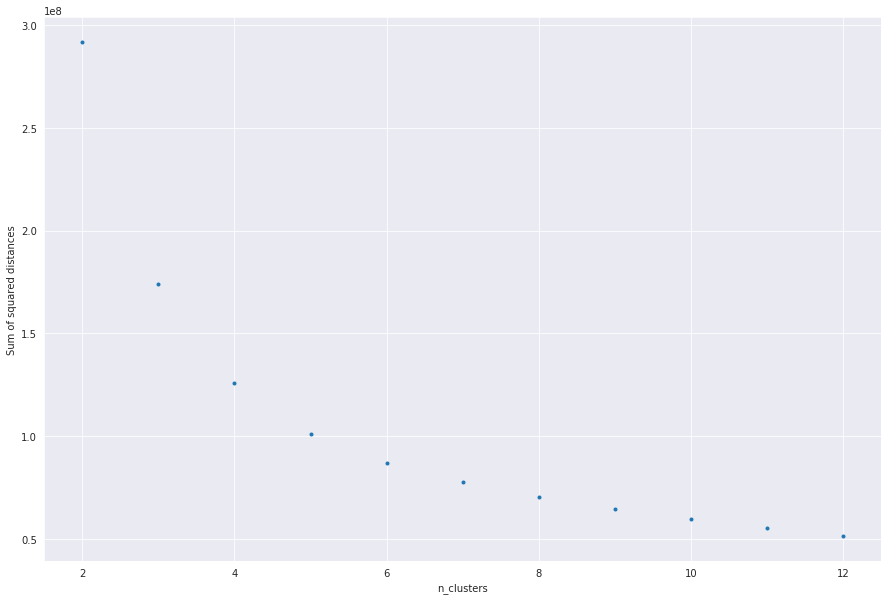

In [35]:
n_clusters = list(range(2,13))
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1)
plt.plot(n_clusters, inertias, '.')
ax.set_xlabel('n_clusters')
ax.set_ylabel('Sum of squared distances')


So let's take n_clusters = 4

In [0]:
kmeans = KMeans(n_clusters=4, random_state=30).fit(all_user_features_df)
user_class_df = pd.DataFrame({'user_class':kmeans.labels_})
user_class_df = user_class_df.reset_index().rename(columns={'index':'user_id'})


Merge to add cluster labels to users

In [0]:
prior_clustered_df = pd.merge(prior_orders_merged_df.loc[:,['user_id', 'product_id']], user_class_df, on='user_id')
train_clustered_df = pd.merge(train_orders_merged_df.loc[:,['user_id', 'product_id']], user_class_df, on='user_id')

In [38]:
prior_clustered_df.head(6)

,user_id,product_id,user_class
0,1,196,1
1,1,14084,1
2,1,12427,1
3,1,26088,1
4,1,26405,1
5,1,196,1


## Visualizing

In [0]:
def postprocess_2d(new_x,y):
  data_df = pd.DataFrame.from_records(data=new_x[:,:2], columns=['x', 'y'])
  data_df["target"] = y
  sns.set(style="ticks")
  sns.lmplot(x='x', y='y',data=data_df,hue = 'target', fit_reg=False)

In [0]:
merged_umap_df = pd.merge(all_user_features_df, user_class_df, on='user_id')

In [0]:
idx = list(set(np.random.randint(0,merged_umap_df.shape[0],1000)))

In [42]:
merged_umap_df.iloc[idx,[1,2,3,4,5,6]]

,median_day_since_prior_order,median_hour_of_day,number_of_orders,median_number_of_products_in_order,reordered,unique_prod_total
69632,11.0,11.0,18,13.0,1,125
22530,15.0,12.0,10,14.0,1,90
53252,30.0,9.0,3,5.0,1,13
36870,17.0,13.5,8,9.0,1,44
4107,8.0,15.0,35,7.0,1,107
...,...,...,...,...,...,...
114679,7.0,12.0,8,11.0,1,39
133112,7.0,12.0,14,15.0,1,104
63481,22.5,11.0,4,3.0,1,12
200699,27.0,15.5,8,9.0,1,25


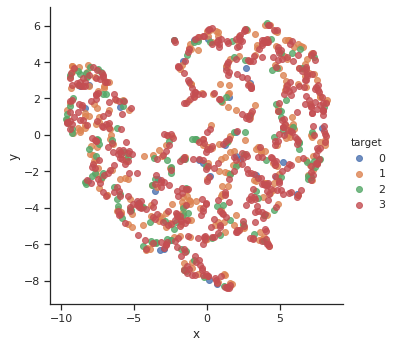

In [44]:
umap = UMAP(n_neighbors=5, min_dist=0.3, metric='correlation')
new_x = umap.fit_transform(merged_umap_df.iloc[idx,[1,2,3,4,5,6]])
postprocess_2d(new_x,merged_umap_df.iloc[idx,[7]].values)

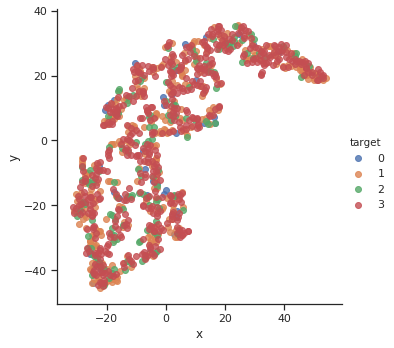

In [45]:
tsne = TSNE(perplexity=30, early_exaggeration=12, learning_rate=200)
new_x = tsne.fit_transform(merged_umap_df.iloc[idx,[1,2,3,4,5,6]])
postprocess_2d(new_x,merged_umap_df.iloc[idx,[7]].values)

## Switcher recommender implementation

In [0]:
class SwitcherRecommender():
  def __init__(self):
    pass
  def fit(self, X_train):
    self.rec_dict = {}
    prior_clustered_grouped_df = X_train.groupby('user_class')
    for cluster_label in X_train['user_class'].unique():
      X_train_cluster = prior_clustered_grouped_df.get_group(cluster_label)
      mp = br.MostPopularRecommender()
      mp.fit(X_train_cluster)
      self.rec_dict[cluster_label] = mp

  def predict(self, X_test, top_n):
      train_clustered_grouped_df = X_test.groupby('user_class')
      predicted = pd.DataFrame()

      for cluster_label in X_test['user_class'].unique():
        X_test_cluster = train_clustered_grouped_df.get_group(cluster_label)
        mp = self.rec_dict[cluster_label]
        cluster_predict = mp.predict(X_test_cluster, top_n)
        predicted = pd.concat([predicted, cluster_predict])
      
      return predicted


In [0]:
switcher_rec = SwitcherRecommender()
switcher_rec.fit(prior_clustered_df)

In [0]:
predicted = switcher_rec.predict(train_clustered_df, top_n=5)

In [53]:
eval_results(train_clustered_df, predicted, 5)

0.06033727618234489

Simple most popular

In [0]:
mp = br.MostPopularRecommender()
mp.fit(prior_orders_merged_df)
predicted = mp.predict(train_orders_merged_df, top_n=5)

In [55]:
eval_results(train_orders_merged_df, predicted, 5)

0.06033834061179575

In [57]:
for class_mp in switcher_rec.rec_dict.values():
  print(len(set(class_mp.most_popular[:50])&set(mp.most_popular[:50])))

50
49
49
49


#MetaRecommender

In [0]:
train_orders_merged_df = pd.merge(orders_df[orders_df['eval_set'] == 'train'], order_products_train_df, on='order_id')
prior_orders_merged_df = pd.merge(orders_df[orders_df['eval_set'] == 'prior'], order_products_prior_df, on='order_id')

Add order_num column to separate prior into train_df and val_df

In [0]:
prior_orders_merged_df = pd.merge(prior_orders_merged_df.groupby('user_id').agg(last_order_number=pd.NamedAgg(column='order_number', aggfunc='max')).reset_index(), prior_orders_merged_df, on='user_id')

Split into train_df and val_df: last order comes into val, all others into train

In [0]:
train_df, val_df = prior_orders_merged_df[prior_orders_merged_df['order_number'] < prior_orders_merged_df['last_order_number']], prior_orders_merged_df[prior_orders_merged_df['order_number'] == prior_orders_merged_df['last_order_number']]

In [61]:
train_df.shape

(30294701, 11)

In [62]:
val_df.shape

(2139788, 11)

Train most popular on train_df and predict on val

In [0]:
mp = br.MostPopularRecommender()
mp.fit(train_df)
predicted_mp = mp.predict(val_df,top_n=5)

In [64]:
svd_rec = br.SVDRecommender(20, 4000)
svd_rec.fit(train_df)
predicted_svd = svd_rec.predict(val_df,top_n=5)

100%|██████████| 51/51 [16:55<00:00, 19.89s/it]


Form ground truth

In [0]:
ground_truth = val_df.groupby('user_id').agg({'product_id':lambda x: list(x)}).reset_index()

Merge all together

In [0]:
all_predict = pd.merge(predicted_svd, predicted_mp, on='user_id')
all_predict = pd.merge(all_predict, ground_truth, on='user_id')

In [0]:
def eval_precision(predicted, actual,k=5):
  return average_precision_at_k(predicted, actual,k)

In [0]:
all_predict['svd_score'] = all_predict.apply(lambda x: eval_precision(x['product_id_x'], x['product_id']), axis=1)
all_predict['mp_score'] = all_predict.apply(lambda x: eval_precision(x['product_id_y'], x['product_id']), axis=1)

Choose best recommender

1 for svd, 0 for most pop

In [0]:
all_predict['best_recommender'] = all_predict.apply(lambda x: 0 if x['mp_score'] >= x['svd_score'] else 1, axis=1)

In [70]:
all_predict

,user_id,product_id_x,product_id_y,product_id,svd_score,mp_score,best_recommender
0,1,"[49235, 13176, 196, 6184, 12341]","[24852, 13176, 21137, 21903, 47209]","[196, 46149, 39657, 38928, 25133, 10258, 35951...",0.066667,0.000000,1
1,2,"[47209, 24852, 47766, 33754, 4957]","[24852, 13176, 21137, 21903, 47209]","[24852, 16589, 1559, 19156, 18523, 22825, 2741...",0.550000,0.280000,1
2,3,"[47766, 21903, 16797, 43352, 5077]","[24852, 13176, 21137, 21903, 47209]","[39190, 18599, 23650, 21903, 47766, 24810]",0.400000,0.050000,1
3,4,"[19057, 28204, 30391, 35951, 39877]","[24852, 13176, 21137, 21903, 47209]","[26576, 25623, 21573]",0.000000,0.000000,0
4,5,"[27966, 16797, 47626, 26209, 26604]","[24852, 13176, 21137, 21903, 47209]","[27344, 24535, 43693, 40706, 16168, 21413, 139...",0.040000,0.000000,1
...,...,...,...,...,...,...,...
206204,206205,"[27845, 49235, 21137, 22035, 5077]","[24852, 13176, 21137, 21903, 47209]","[27845, 21137, 43352, 3896, 19173, 22035, 38739]",0.483333,0.066667,1
206205,206206,"[27086, 5785, 49235, 26209, 19057]","[24852, 13176, 21137, 21903, 47209]","[11520, 23029, 42623]",0.000000,0.000000,0
206206,206207,"[13176, 44632, 27966, 35221, 21709]","[24852, 13176, 21137, 21903, 47209]","[27845, 36011, 39180, 13176, 33787, 44632, 337...",0.600000,0.100000,1
206207,206208,"[13176, 27845, 27966, 21137, 26209]","[24852, 13176, 21137, 21903, 47209]","[13176, 34213, 23579, 33000, 31404, 35688, 236...",0.200000,0.100000,1


Generate features

In [0]:
train_only_features_df = generate_features(train_df)
train_val_features_df = generate_features(prior_orders_merged_df)

In [0]:
full_train_df = pd.merge(train_only_features_df, all_predict.loc[:,['user_id','best_recommender']], on='user_id')

In [0]:
full_test_df = train_val_features_df.loc[:,['median_day_since_prior_order',	'median_hour_of_day','number_of_orders','median_number_of_products_in_order','reordered','unique_prod_total']]

Train metaclassifier

In [0]:
clf = LogisticRegression()

In [76]:
clf.fit(full_train_df.loc[:,['median_day_since_prior_order',	'median_hour_of_day','number_of_orders','median_number_of_products_in_order','reordered','unique_prod_total']],
        full_train_df['best_recommender'])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

User for which we need prediction

In [0]:
users = list(set(train_orders_merged_df['user_id'].unique()) & set(prior_orders_merged_df['user_id'].unique()))

In [0]:
pred = clf.predict(train_val_features_df.loc[users,:])

In [79]:
pred.shape

(131209,)

In [0]:
X_test = pd.DataFrame({'user_id' : train_val_features_df.loc[users,:].index, 'best_recommender':pred})

In [0]:
X_test_mp = X_test.query('best_recommender == 0')
X_test_svd = X_test.query('best_recommender == 1')

Predict using corresponding recommender. We retrain both recommenders on train + val = prior

In [0]:
mp = br.MostPopularRecommender()
mp.fit(prior_orders_merged_df)
predicted_mp = mp.predict(X_test_mp,top_n=5)

In [83]:
svd_rec = br.SVDRecommender(20, 4000)
svd_rec.fit(prior_orders_merged_df)
predicted_svd = svd_rec.predict(X_test_svd,top_n=5)

100%|██████████| 6/6 [01:59<00:00, 19.94s/it]


Concat predictions

In [0]:
full_predict = pd.concat([predicted_mp, predicted_svd.reset_index()])
full_predict.sort_values(by='user_id', inplace=True)

Finally, eval performance

In [85]:
eval_results(train_orders_merged_df, full_predict,k=5)

0.0841528041352467